Epoch 1/50


/Users/hashishtekkali/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  3/449 ━━━━━━━━━━━━━━━━━━━━ 17s 39ms/step - accuracy: 0.1432 - loss: 1.9530  

/Users/hashishtekkali/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


449/449 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - accuracy: 0.2351 - loss: 1.8360 - val_accuracy: 0.2565 - val_loss: 1.7733 - learning_rate: 0.0010
Epoch 2/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 17s 38ms/step - accuracy: 0.2554 - loss: 1.7863 - val_accuracy: 0.2990 - val_loss: 1.7034 - learning_rate: 0.0010
Epoch 3/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - accuracy: 0.2829 - loss: 1.7434 - val_accuracy: 0.3306 - val_loss: 1.6423 - learning_rate: 0.0010
Epoch 4/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 17s 38ms/step - accuracy: 0.3061 - loss: 1.7118 - val_accuracy: 0.3911 - val_loss: 1.5461 - learning_rate: 0.0010
Epoch 5/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 17s 38ms/step - accuracy: 0.3353 - loss: 1.6616 - val_accuracy: 0.4277 - val_loss: 1.4712 - learning_rate: 0.0010
Epoch 6/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 18s 40ms/step - accuracy: 0.3628 - loss: 1.6118 - val_accuracy: 0.4617 - val_loss: 1.4192 - learning_rate: 0.0010
Epoch 7/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 17s 38ms/step - accuracy: 0.3856 - loss: 1.5708

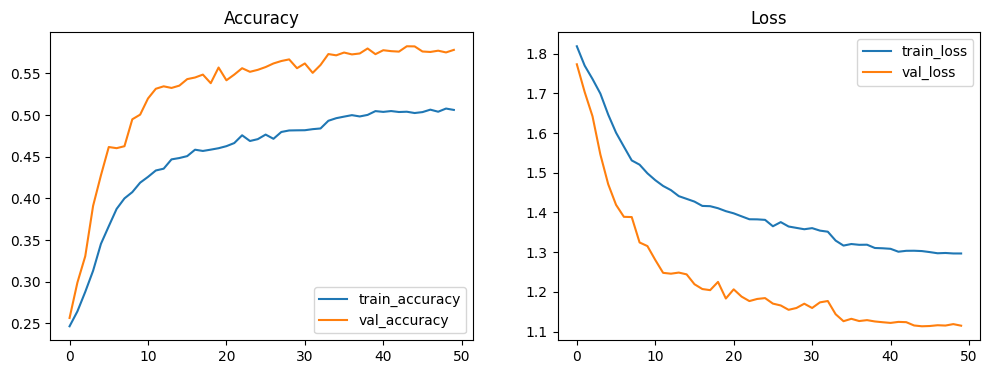

In [16]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Load and preprocess the dataset
def load_data(file_path):
    data = pd.read_csv(file_path)
    pixels = data['pixels'].tolist()
    width, height = 48, 48
    faces = []
    for pixel_sequence in pixels:
        face = np.asarray([int(pixel) for pixel in pixel_sequence.split(' ')], dtype=np.uint8).reshape(width, height)
        faces.append(face)
    faces = np.expand_dims(np.array(faces), -1)
    emotions = pd.get_dummies(data['emotion']).values
    return faces, emotions

# File path to the FER-2013 dataset CSV file
file_path = 'fer2013.csv'

# Load the data
faces, emotions = load_data(file_path)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(faces, emotions, test_size=0.2, random_state=42)

# Data augmentation
data_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

val_gen = ImageDataGenerator(rescale=1./255)

# Build the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(7, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# Train the model
history = model.fit(
    data_gen.flow(X_train, y_train, batch_size=64),
    validation_data=val_gen.flow(X_val, y_val),
    epochs=50,
    callbacks=[early_stopping, reduce_lr]
)

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.title('Loss')

plt.show()

# Save the model
model.save('emotion_recognition_model.keras')


EMOTION DETECTION TRAINED MODEL


In [17]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
import mediapipe as mp
import matplotlib.pyplot as plt
from collections import defaultdict

# Load the trained model
model = load_model('emotion_recognition_model.keras')

# Emotion labels
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# Initialize Mediapipe Face Mesh
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh()

# Function to preprocess the image
def preprocess_image(image):
    image = cv2.resize(image, (48, 48))  # Resize image to 48x48
    image = image / 255.0  # Normalize pixel values
    image = np.expand_dims(image, axis=-1)  # Add a channel dimension
    image = np.expand_dims(image, axis=0)  # Add a batch dimension
    return image

# Function to plot emotion statistics
def plot_emotion_statistics(emotion_counts):
    emotions = list(emotion_counts.keys())
    counts = list(emotion_counts.values())
    
    fig, ax = plt.subplots(figsize=(4, 3), dpi=100)
    ax.bar(emotions, counts, color='skyblue')
    ax.set_title('Emotion Frequency')
    ax.set_xlabel('Emotions')
    ax.set_ylabel('Frequency')
    
    plt.tight_layout()
    fig.canvas.draw()
    
    # Convert plot to image
    plot_img = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    plot_img = plot_img.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    plt.close(fig)
    return plot_img

# Initialize emotion counts
emotion_counts = defaultdict(int)

# Start video capture
cap = cv2.VideoCapture(0)

while True:
    start_time = cv2.getTickCount()

    ret, frame = cap.read()
    if not ret:
        break

    # Detect faces in the frame using OpenCV's Haar Cascade
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray_frame, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    for (x, y, w, h) in faces:
        # Extract the region of interest (ROI) and preprocess it
        roi = gray_frame[y:y+h, x:x+w]
        processed_roi = preprocess_image(roi)

        # Predict emotion
        prediction = model.predict(processed_roi)
        max_index = np.argmax(prediction)
        emotion = emotion_labels[max_index]

        # Update emotion count
        emotion_counts[emotion] += 1

        # Display the label on the frame
        cv2.putText(frame, emotion, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)

        # Draw face mesh with landmarks
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = face_mesh.process(rgb_frame)
        if results.multi_face_landmarks:
            for face_landmarks in results.multi_face_landmarks:
                for idx, lm in enumerate(face_landmarks.landmark):
                    ih, iw, _ = frame.shape
                    x_lm, y_lm = int(lm.x * iw), int(lm.y * ih)
                    cv2.circle(frame, (x_lm, y_lm), 1, (0, 255, 0), -1)

    # Calculate and display the frame rate (FPS)
    end_time = cv2.getTickCount()
    time_taken = (end_time - start_time) / cv2.getTickFrequency()
    fps = 1 / time_taken
    cv2.putText(frame, f'FPS: {int(fps)}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)

    # Plot and embed emotion statistics chart in the frame
    plot_img = plot_emotion_statistics(emotion_counts)
    plot_img = cv2.cvtColor(plot_img, cv2.COLOR_RGB2BGR)  # Convert RGB to BGR for OpenCV
    frame[10:10+plot_img.shape[0], frame.shape[1]-10-plot_img.shape[1]:frame.shape[1]-10] = plot_img

    # Display the frame
    cv2.imshow('Emotion Recognition', frame)

    # Break the loop on 'q' key press
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the video capture and close windows
cap.release()
cv2.destroyAllWindows()


I0000 00:00:1717671350.912699 1615490 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M2
W0000 00:00:1717671350.924406 1680372 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1717671350.926486 1680372 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


THE CHAT FLOW
OF THE EMOTIONS DETECTED


In [14]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
import mediapipe as mp
import matplotlib.pyplot as plt
from collections import defaultdict, deque
import time

# Load the trained model
model = load_model('emotion_recognition_model.keras')

# Emotion labels
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# Initialize Mediapipe Face Mesh
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh()

# Function to preprocess the image
def preprocess_image(image):
    image = cv2.resize(image, (48, 48))  # Resize image to 48x48
    image = image / 255.0  # Normalize pixel values
    image = np.expand_dims(image, axis=-1)  # Add a channel dimension
    image = np.expand_dims(image, axis=0)  # Add a batch dimension
    return image

# Function to plot emotion statistics in different chart formats
def plot_emotion_statistics(emotion_counts):
    emotions = list(emotion_counts.keys())
    counts = list(emotion_counts.values())
    
    # Bar chart
    fig, ax = plt.subplots(1, 3, figsize=(18, 6), dpi=100)
    
    ax[0].bar(emotions, counts, color='skyblue')
    ax[0].set_title('Emotion Frequency - Bar Chart')
    ax[0].set_xlabel('Emotions')
    ax[0].set_ylabel('Frequency')
    
    # Pie chart
    ax[1].pie(counts, labels=emotions, autopct='%1.1f%%', colors=plt.cm.Paired(range(len(emotions))))
    ax[1].set_title('Emotion Frequency - Pie Chart')
    
    # Line chart
    ax[2].plot(emotions, counts, marker='o', color='skyblue')
    ax[2].set_title('Emotion Frequency - Line Chart')
    ax[2].set_xlabel('Emotions')
    ax[2].set_ylabel('Frequency')
    
    plt.tight_layout()
    fig.canvas.draw()
    
    # Convert plot to image
    plot_img = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    plot_img = plot_img.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    plt.close(fig)
    return plot_img

# Initialize emotion counts
emotion_counts = defaultdict(int)

# Start video capture
cap = cv2.VideoCapture(0)

# Track time for 60-second interval
start_time = time.time()
frame_buffer = deque(maxlen=60 * int(cap.get(cv2.CAP_PROP_FPS)))

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Detect faces in the frame using OpenCV's Haar Cascade
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray_frame, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    for (x, y, w, h) in faces:
        # Extract the region of interest (ROI) and preprocess it
        roi = gray_frame[y:y+h, x:x+w]
        processed_roi = preprocess_image(roi)

        # Predict emotion
        prediction = model.predict(processed_roi)
        max_index = np.argmax(prediction)
        emotion = emotion_labels[max_index]

        # Update emotion count
        emotion_counts[emotion] += 1

        # Display the label on the frame
        cv2.putText(frame, emotion, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)

        # Draw face mesh with landmarks
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = face_mesh.process(rgb_frame)
        if results.multi_face_landmarks:
            for face_landmarks in results.multi_face_landmarks:
                for idx, lm in enumerate(face_landmarks.landmark):
                    ih, iw, _ = frame.shape
                    x_lm, y_lm = int(lm.x * iw), int(lm.y * ih)
                    cv2.circle(frame, (x_lm, y_lm), 1, (0, 255, 0), -1)

    # Calculate and display the frame rate (FPS)
    end_time = time.time()
    time_taken = end_time - start_time
    fps = cap.get(cv2.CAP_PROP_FPS)
    cv2.putText(frame, f'FPS: {int(fps)}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)

    # Plot and embed emotion statistics chart in the frame
    plot_img = plot_emotion_statistics(emotion_counts)
    plot_img = cv2.cvtColor(plot_img, cv2.COLOR_RGB2BGR)  # Convert RGB to BGR for OpenCV
    frame[10:10+plot_img.shape[0], frame.shape[1]-10-plot_img.shape[1]:frame.shape[1]-10] = plot_img

    # Display the frame
    cv2.imshow('Emotion Recognition', frame)

    # Break the loop on 'q' key press or after 60 seconds
    if cv2.waitKey(1) & 0xFF == ord('q') or time_taken >= 60:
        break

# Calculate and print the dominant emotion and suggestions
total_emotions = sum(emotion_counts.values())
if total_emotions > 0:
    sorted_emotions = sorted(emotion_counts.items(), key=lambda item: item[1], reverse=True)
    dominant_emotion = sorted_emotions[0][0]
    print(f'Dominant Emotion: {dominant_emotion}')
    
    if dominant_emotion == 'Happy':
        print("The person is emotionally well.")
        suggestions = [
            "Keep doing what makes you happy.",
            "Continue to maintain a positive outlook.",
            "Engage in activities that bring you joy and satisfaction."
        ]
    elif dominant_emotion == 'Sad':
        print("The person may have some emotional conditions.")
        suggestions = [
            "Connect with others and talk about your feelings.",
            "Engage in regular physical activity.",
            "Practice mindfulness and meditation.",
            "Seek professional help if needed."
        ]
    elif dominant_emotion == 'Angry':
        print("The person may have some emotional conditions.")
        suggestions = [
            "Identify and manage your anger triggers.",
            "Practice deep breathing exercises.",
            "Engage in relaxation techniques.",
            "Seek professional help if needed."
        ]
    elif dominant_emotion == 'Fear':
        print("The person may have some emotional conditions.")
        suggestions = [
            "Gradually expose yourself to what you fear.",
            "Educate yourself about your fears.",
            "Practice positive visualization and relaxation techniques.",
            "Seek professional help if needed."
        ]
    else:
        print("The person is emotionally neutral or has mixed emotions.")
        suggestions = [
            "Maintain a healthy lifestyle with regular exercise and good nutrition.",
            "Engage in hobbies and activities you enjoy.",
            "Practice mindfulness and gratitude."
        ]

    # Print suggestions
    print("Suggestions to improve emotional well-being:")
    for suggestion in suggestions:
        print(f"- {suggestion}")
else:
    print("No dominant emotion detected.")

# Display final emotion statistics
plt.figure(figsize=(10, 4))
plt.subplot(1, 3, 1)
plt.bar(emotion_counts.keys(), emotion_counts.values(), color='skyblue')
plt.title('Emotion Frequency - Bar Chart')
plt.xlabel('Emotions')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
plt.pie(emotion_counts.values(), labels=emotion_counts.keys(), autopct='%1.1f%%', colors=plt.cm.Paired(range(len(emotion_counts))))
plt.title('Emotion Frequency - Pie Chart')

plt.subplot(1, 3, 3)
plt.plot(list(emotion_counts.keys()), list(emotion_counts.values()), marker='o', color='skyblue')
plt.title('Emotion Frequency - Line Chart')
plt.xlabel('Emotions')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Release the video capture and close windows
cap.release()
cv2.destroyAllWindows()


I0000 00:00:1717754088.539704 1747144 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M2
W0000 00:00:1717754088.554954 1803477 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1717754088.556885 1803477 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


/var/folders/68/8b1n13v93mlgb_z3n0d9jwwc0000gn/T/ipykernel_43987/3949144801.py:55: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  plot_img = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)


ValueError: could not broadcast input array from shape (600,1800,3) into shape (600,520,3)

PARKINSON TRAINED DATA

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import pickle

# Load the CSV file into a DataFrame
file_path = 'parkinson.csv'  # Replace with your actual file path
df = pd.read_csv(file_path)

# Drop non-numeric columns
df = df.drop(columns=['name'])  # Drop any non-numeric columns that are not features

# Assume the target column is named 'status' where 1 indicates Parkinson's disease and 0 indicates no disease
X = df.drop(columns=['status'])  # Features
y = df['status']  # Target

# Ensure all features are numeric
X = X.apply(pd.to_numeric, errors='coerce')

# Drop rows with any NaN values that resulted from coercion
X = X.dropna()

# Make sure y is aligned with X after dropping rows
y = y[X.index]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the feature values
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize and train a Logistic Regression model
model = LogisticRegression()
model.fit(X_train_scaled, y_train)

# Evaluate the model
y_pred = model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

# Save the model and scaler for later use
with open('parkinsons_model.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)
with open('scaler.pkl', 'wb') as scaler_file:
    pickle.dump(scaler, scaler_file)



Accuracy: 0.8974358974358975
Confusion Matrix:
[[ 3  4]
 [ 0 32]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.43      0.60         7
           1       0.89      1.00      0.94        32

    accuracy                           0.90        39
   macro avg       0.94      0.71      0.77        39
weighted avg       0.91      0.90      0.88        39



PARKINSON DETECTION


In [2]:
pip install sounddevice scipy librosa opencv-python


Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 260 kB 1.2 MB/s eta 0:00:01
     |████████████████████████████████| 390 kB 2.2 MB/s eta 0:00:01
     |████████████████████████████████| 62 kB 3.8 MB/s  eta 0:00:01
     |████████████████████████████████| 1.1 MB 3.8 MB/s eta 0:00:01
     |████████████████████████████████| 2.6 MB 3.8 MB/s eta 0:00:01
     |████████████████████████████████| 85 kB 2.9 MB/s eta 0:00:01
     |████████████████████████████████| 28.8 MB 4.8 MB/s eta 0:00:011
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import sounddevice as sd
import numpy as np
import librosa
import pickle
import pandas as pd
import time
import threading

# Define the text to read
text_to_read = """
Parkinson's disease is a progressive nervous system disorder that affects movement. 
Symptoms start gradually, sometimes starting with a barely noticeable tremor in just one hand. 
Tremors are common, but the disorder also commonly causes stiffness or slowing of movement. 
In the early stages of Parkinson's disease, your face may show little or no expression. 
Your arms may not swing when you walk. Your speech may become soft or slurred. 
Parkinson's disease symptoms worsen as your condition progresses over time.
Although Parkinson's disease can't be cured, medications might significantly improve your symptoms.
Occasionally, your doctor may suggest surgery to regulate certain regions of your brain and improve your symptoms.
"""

# Load the model and scaler
with open('parkinsons_model.pkl', 'rb') as model_file:
    model = pickle.load(model_file)
with open('scaler.pkl', 'rb') as scaler_file:
    scaler = pickle.load(scaler_file)

# Corrected feature extraction function
def extract_features(y, sr):
    features = {}
    fo = librosa.yin(y, fmin=75, fmax=450)
    features['MDVP:Fo(Hz)'] = np.mean(fo)
    features['MDVP:Fhi(Hz)'] = np.max(fo)
    features['MDVP:Flo(Hz)'] = np.min(fo)
    features['MDVP:Jitter(%)'] = np.mean(librosa.feature.zero_crossing_rate(y=y))
    features['MDVP:Jitter(Abs)'] = np.std(librosa.feature.zero_crossing_rate(y=y))
    features['MDVP:RAP'] = np.mean(librosa.feature.rms(y=y))
    features['MDVP:PPQ'] = np.std(librosa.feature.rms(y=y))
    features['Jitter:DDP'] = np.mean(np.abs(np.diff(librosa.feature.zero_crossing_rate(y=y))))
    features['MDVP:Shimmer'] = np.mean(librosa.feature.spectral_flatness(y=y))
    features['MDVP:Shimmer(dB)'] = np.std(librosa.feature.spectral_flatness(y=y))
    features['Shimmer:APQ3'] = np.mean(librosa.feature.mfcc(y=y, sr=sr))
    features['Shimmer:APQ5'] = np.std(librosa.feature.mfcc(y=y, sr=sr))
    features['MDVP:APQ'] = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))
    features['Shimmer:DDA'] = np.std(librosa.feature.spectral_bandwidth(y=y, sr=sr))
    features['NHR'] = np.mean(librosa.effects.harmonic(y=y))
    features['HNR'] = np.std(librosa.effects.harmonic(y=y))
    features['RPDE'] = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))
    features['DFA'] = np.std(librosa.feature.spectral_rolloff(y=y, sr=sr))
    features['spread1'] = np.mean(librosa.feature.spectral_contrast(y=y, sr=sr))
    features['spread2'] = np.std(librosa.feature.spectral_contrast(y=y, sr=sr))
    features['D2'] = np.mean(librosa.feature.delta(librosa.feature.mfcc(y=y, sr=sr)))
    features['PPE'] = np.std(librosa.feature.delta(librosa.feature.mfcc(y=y, sr=sr)))
    return features

# Function to predict Parkinson's disease
def predict_parkinson(features):
    input_df = pd.DataFrame([features])
    input_df = input_df.apply(pd.to_numeric, errors='coerce')
    input_scaled = scaler.transform(input_df)
    prediction_proba = model.predict_proba(input_scaled)[0][1]  # Get probability of the positive class
    return prediction_proba

# Function to record audio for 60 seconds
def record_audio(duration=60, sr=22050):
    print("Recording...")
    audio = sd.rec(int(duration * sr), samplerate=sr, channels=1, dtype='float64')
    sd.wait()  # Wait until recording is finished
    print("Recording finished")
    return audio.flatten(), sr

# Function to display text while recording
def display_text(text, duration):
    start_time = time.time()
    print("Please read the following text aloud:")
    print("\n" + text + "\n")
    while time.time() - start_time < duration:
        time.sleep(1)

# Display text and record audio simultaneously
text_thread = threading.Thread(target=display_text, args=(text_to_read, 60))
text_thread.start()
audio, sr = record_audio(60)
text_thread.join()

# Extract features from the recorded audio
features = extract_features(audio, sr)

# Predict Parkinson's disease
prediction_proba = predict_parkinson(features)
threshold = 0.5  # You can adjust this threshold based on your model's performance
if prediction_proba >= threshold:
    print("The model predicts that you have Parkinson's disease.")
else:
    print("The model predicts that you do not have Parkinson's disease.")


Please read the following text aloud:Recording...



Parkinson's disease is a progressive nervous system disorder that affects movement. 
Symptoms start gradually, sometimes starting with a barely noticeable tremor in just one hand. 
Tremors are common, but the disorder also commonly causes stiffness or slowing of movement. 
In the early stages of Parkinson's disease, your face may show little or no expression. 
Your arms may not swing when you walk. Your speech may become soft or slurred. 
Parkinson's disease symptoms worsen as your condition progresses over time.
Although Parkinson's disease can't be cured, medications might significantly improve your symptoms.
Occasionally, your doctor may suggest surgery to regulate certain regions of your brain and improve your symptoms.


Recording finished
The model predicts that you have Parkinson's disease.


THE MAIN PROJECT CODE


I0000 00:00:1718302146.353113 2705814 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M2
W0000 00:00:1718302146.358675 2729325 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1718302146.366135 2729326 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


/var/folders/68/8b1n13v93mlgb_z3n0d9jwwc0000gn/T/ipykernel_56406/337228950.py:59: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  plot_img = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
/Users/hashishtekkali/Library/Python/3.9/lib/python/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


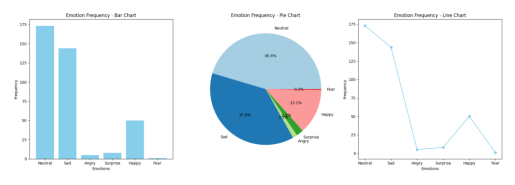

The person is emotionally neutral.
Suggestions:
- Maintain a balanced lifestyle.
- Engage in activities that promote emotional well-being.
Recommended Songs:
- Last Resort
- Are You Gonna Be My Girl
- The Middle
- Smooth Criminal
- Can't Stop


In [3]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
import mediapipe as mp
import matplotlib.pyplot as plt
from collections import defaultdict, deque
import time
import pandas as pd

# Load the song dataset
song_data = pd.read_csv('song_data.csv')

# Load the trained model
model = load_model('emotion_recognition_model.keras')

# Emotion labels
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# Initialize Mediapipe Face Mesh
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh()

# Function to preprocess the image
def preprocess_image(image):
    image = cv2.resize(image, (48, 48))  # Resize image to 48x48
    image = image / 255.0  # Normalize pixel values
    image = np.expand_dims(image, axis=-1)  # Add a channel dimension
    image = np.expand_dims(image, axis=0)  # Add a batch dimension
    return image

# Function to plot emotion statistics in different chart formats
def plot_emotion_statistics(emotion_counts):
    emotions = list(emotion_counts.keys())
    counts = list(emotion_counts.values())
    
    # Bar chart
    fig, ax = plt.subplots(1, 3, figsize=(18, 6), dpi=100)
    
    ax[0].bar(emotions, counts, color='skyblue')
    ax[0].set_title('Emotion Frequency - Bar Chart')
    ax[0].set_xlabel('Emotions')
    ax[0].set_ylabel('Frequency')
    
    # Pie chart
    ax[1].pie(counts, labels=emotions, autopct='%1.1f%%', colors=plt.cm.Paired(range(len(emotions))))
    ax[1].set_title('Emotion Frequency - Pie Chart')
    
    # Line chart
    ax[2].plot(emotions, counts, marker='o', color='skyblue')
    ax[2].set_title('Emotion Frequency - Line Chart')
    ax[2].set_xlabel('Emotions')
    ax[2].set_ylabel('Frequency')
    
    plt.tight_layout()
    fig.canvas.draw()
    
    # Convert plot to image
    plot_img = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    plot_img = plot_img.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    plt.close(fig)
    return plot_img

# Function to recommend songs based on the dominant emotion
def recommend_songs(emotion, song_data, top_n=5):
    if emotion == 'Happy':
        filtered_songs = song_data[(song_data['danceability'] > 0.7) & (song_data['energy'] > 0.7) & (song_data['audio_valence'] > 0.7)]
    elif emotion == 'Sad':
        filtered_songs = song_data[(song_data['audio_valence'] < 0.4) & (song_data['tempo'] < 100)]
    elif emotion == 'Angry':
        filtered_songs = song_data[(song_data['energy'] > 0.7) & (song_data['loudness'] > -5)]
    elif emotion == 'Fear':
        filtered_songs = song_data[(song_data['audio_valence'] < 0.4) & (song_data['tempo'] > 100) & (song_data['tempo'] < 140)]
    elif emotion == 'Surprise':
        filtered_songs = song_data[(song_data['audio_valence'] > 0.7) & (song_data['tempo'] > 140)]
    else:  # Neutral or other emotions
        filtered_songs = song_data[(song_data['danceability'] > 0.5) & (song_data['energy'] > 0.5) & (song_data['audio_valence'] > 0.5)]
    
    recommended_songs = filtered_songs.head(top_n)
    return recommended_songs

# Initialize emotion counts
emotion_counts = defaultdict(int)

# Start video capture
cap = cv2.VideoCapture(0)

# Track time for 60-second interval
start_time = time.time()
frame_buffer = deque(maxlen=60 * int(cap.get(cv2.CAP_PROP_FPS)))

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Detect faces in the frame using OpenCV's Haar Cascade
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray_frame, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    for (x, y, w, h) in faces:
        # Extract the region of interest (ROI) and preprocess it
        roi = gray_frame[y:y+h, x:x+w]
        processed_roi = preprocess_image(roi)

        # Predict emotion
        prediction = model.predict(processed_roi)
        max_index = np.argmax(prediction)
        emotion = emotion_labels[max_index]

        # Update emotion count
        emotion_counts[emotion] += 1

        # Display the label on the frame
        cv2.putText(frame, emotion, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)

        # Draw face mesh with landmarks
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = face_mesh.process(rgb_frame)
        if results.multi_face_landmarks:
            for face_landmarks in results.multi_face_landmarks:
                for idx, lm in enumerate(face_landmarks.landmark):
                    ih, iw, _ = frame.shape
                    x_lm, y_lm = int(lm.x * iw), int(lm.y * ih)
                    cv2.circle(frame, (x_lm, y_lm), 1, (0, 255, 0), -1)

    # Calculate and display the frame rate (FPS)
    end_time = time.time()
    time_taken = end_time - start_time
    fps = cap.get(cv2.CAP_PROP_FPS)
    cv2.putText(frame, f'FPS: {int(fps)}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)

    # Plot and embed emotion statistics chart in the frame
    plot_img = plot_emotion_statistics(emotion_counts)
    plot_img = cv2.cvtColor(plot_img, cv2.COLOR_RGB2BGR)  # Convert RGB to BGR for OpenCV

    # Resize plot image to fit the frame if necessary
    frame_height, frame_width = frame.shape[:2]
    plot_height, plot_width = plot_img.shape[:2]
    max_width = frame_width // 3  # Assuming we want the plot to occupy 1/3rd of the frame width
    if plot_width > max_width:
        scaling_factor = max_width / plot_width
        new_width = int(plot_width * scaling_factor)
        new_height = int(plot_height * scaling_factor)
        plot_img = cv2.resize(plot_img, (new_width, new_height))

    # Overlay plot image on the frame
    plot_height, plot_width = plot_img.shape[:2]
    frame[10:10+plot_height, frame_width-10-plot_width:frame_width-10] = plot_img

    # Display the frame
    cv2.imshow('Emotion Recognition', frame)

    # Break the loop on 'q' key press or after 60 seconds
    if cv2.waitKey(1) & 0xFF == ord('q') or time_taken >= 60:
        break

# Calculate and print the dominant emotion and suggestions
total_emotions = sum(emotion_counts.values())
if total_emotions > 0:
    sorted_emotions = sorted(emotion_counts.items(), key=lambda item: item[1], reverse=True)
    dominant_emotion = sorted_emotions[0][0]
    print(f'Dominant Emotion: {dominant_emotion}')
    
    # Plot and display emotion statistics
    plot_img = plot_emotion_statistics(emotion_counts)
    plt.imshow(plot_img)
    plt.axis('off')
    plt.show()
    
    # Print suggestions based on the dominant emotion
    if dominant_emotion == 'Happy':
        print("The person is emotionally well.")
        suggestions = [
            "Keep doing what makes you happy.",
            "Continue to maintain a positive outlook.",
            "Engage in activities that bring you joy and satisfaction."
        ]
    elif dominant_emotion == 'Sad':
        print("The person may have some emotional conditions.")
        suggestions = [
            "Connect with others and talk about your feelings.",
            "Engage in regular physical activity.",
            "Practice mindfulness and meditation.",
            "Seek professional help if needed."
        ]
    elif dominant_emotion == 'Angry':
        print("The person may have some emotional conditions.")
        suggestions = [
            "Identify and manage your anger triggers.",
            "Practice deep breathing exercises.",
            "Engage in relaxation techniques.",
            "Seek professional help if needed."
        ]
    elif dominant_emotion == 'Fear':
        print("The person may have some emotional conditions.")
        suggestions = [
            "Identify and confront your fears.",
            "Practice relaxation techniques.",
            "Seek professional help if needed."
        ]
    elif dominant_emotion == 'Surprise':
        print("The person may have some emotional conditions.")
        suggestions = [
            "Reflect on what caused the surprise.",
            "Maintain a balanced perspective.",
            "Seek professional help if needed."
        ]
    else:
        print("The person is emotionally neutral.")
        suggestions = [
            "Maintain a balanced lifestyle.",
            "Engage in activities that promote emotional well-being."
        ]
    
    print("Suggestions:")
    for suggestion in suggestions:
        print(f"- {suggestion}")

    # Plot and display recommended songs based on the dominant emotion
    recommended_songs = recommend_songs(dominant_emotion, song_data)
    print("Recommended Songs:")
    for idx, song in recommended_songs.iterrows():
        print(f"- {song['song_name']}")


# Release the video capture and close windows
cap.release()
cv2.destroyAllWindows()


In [5]:
import pandas as pd

# Load the song dataset
song_data = pd.read_csv('song_data.csv')

# Print column names to inspect
print(song_data.columns)


Index(['song_name', 'song_popularity', 'song_duration_ms', 'acousticness',
       'danceability', 'energy', 'instrumentalness', 'key', 'liveness',
       'loudness', 'audio_mode', 'speechiness', 'tempo', 'time_signature',
       'audio_valence'],
      dtype='object')


In [11]:
pip install openpyxl

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 251 kB 1.1 MB/s eta 0:00:01
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


FOR THE EXCEL FILE


In [12]:
import pandas as pd

# Create a DataFrame with emotion statistics
emotion_df = pd.DataFrame(emotion_counts.items(), columns=['Emotion', 'Frequency'])

# Calculate dominant emotion and suggestions
total_emotions = sum(emotion_counts.values())
if total_emotions > 0:
    sorted_emotions = sorted(emotion_counts.items(), key=lambda item: item[1], reverse=True)
    dominant_emotion = sorted_emotions[0][0]
    
    # Define suggestions based on the dominant emotion
    if dominant_emotion == 'Happy':
        suggestions = [
            "Keep doing what makes you happy.",
            "Continue to maintain a positive outlook.",
            "Engage in activities that bring you joy and satisfaction."
        ]
    elif dominant_emotion == 'Sad':
        suggestions = [
            "Connect with others and talk about your feelings.",
            "Engage in regular physical activity.",
            "Practice mindfulness and meditation.",
            "Seek professional help if needed."
        ]
    elif dominant_emotion == 'Angry':
        suggestions = [
            "Identify and manage your anger triggers.",
            "Practice deep breathing exercises.",
            "Engage in relaxation techniques.",
            "Seek professional help if needed."
        ]
    elif dominant_emotion == 'Fear':
        suggestions = [
            "Identify and confront your fears.",
            "Practice relaxation techniques.",
            "Seek professional help if needed."
        ]
    elif dominant_emotion == 'Surprise':
        suggestions = [
            "Reflect on what caused the surprise.",
            "Maintain a balanced perspective.",
            "Seek professional help if needed."
        ]
    else:
        suggestions = [
            "Maintain a balanced lifestyle.",
            "Engage in activities that promote emotional well-being."
        ]

    # Create a DataFrame for suggestions
    suggestions_df = pd.DataFrame({'Suggestion': suggestions})

    # Create a DataFrame for recommended songs
    recommended_songs = recommend_songs(dominant_emotion, song_data)
    recommended_songs_df = recommended_songs[['song_name']]

    # Write DataFrames to an Excel file
    with pd.ExcelWriter('emotion_analysis_results.xlsx') as writer:
        emotion_df.to_excel(writer, sheet_name='Emotion Statistics', index=False)
        suggestions_df.to_excel(writer, sheet_name='Suggestions', index=False)
        recommended_songs_df.to_excel(writer, sheet_name='Recommended Songs', index=False)
